<a href="https://colab.research.google.com/github/psasanka1729/Ultimate-QM-MM/blob/main/shadow_tomography_qiskit_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit.quantum_info import Statevector
from qiskit import*

In [2]:
I2 = np.matrix([[1,0],
                [0,1]])
H  = np.matrix([[1,1],
                [1,-1]])* (1/np.sqrt(2))
S  = np.matrix([[1,0],
                [0,1j]])
X  = np.matrix([[0,1],
                [1,0]])
Y  = np.matrix([[0,-1j],
                [1j,0]])
Z  = np.matrix([[1,0],
                [0,-1]])

In [3]:
def commutator(matrix_a,matrix_b):
    return matrix_a@matrix_b - matrix_b@matrix_a
def anti_commutator(matrix_a,matrix_b):
    return matrix_a@matrix_b + matrix_b@matrix_a

In [4]:
N_qubit = 2
# returns N*K classical shadows.
def classical_shadow_using_ST(N,K,theta_x,theta_y,theta_z,theta_ry):

    # setting up the quantum circuit
    qc = QuantumCircuit(N_qubit)
    # initializing the ancilla qubit at |0>.
    qc.initialize([1,0],0)
    qc.rx(theta_x,1)
    qc.ry(theta_y,1)
    qc.rz(theta_z,1)
    qc.cry(theta_ry,1,0)

    # qiskit returns the statevector as a row.
    # taking transpose to make it a column vector.
    sv = np.matrix(Statevector.from_instruction(qc)).T
    rho_SS = sv@(sv.conj().T)

    # number of shadows
    nShadows = N*K
    # number of shots
    number_of_shots = 1
    #rng = np.random.default_rng(1000)
    cliffords = [qiskit.quantum_info.random_clifford(N_qubit) for _ in range(nShadows)]
    results = []
    for cliff in cliffords:
        qc_c  = qc.compose(cliff.to_circuit())
        # samples the output in computational basis.
        counts = qiskit.quantum_info.Statevector(qc_c).sample_counts(number_of_shots)
        results.append(counts)

    # performing rho_hat = (2**N+1)*(U^{\dagger}|b><b|U-I).
    shadow_lst = []
    # loops over the clifford gates and their corresponding measurement results.
    for cliff, res in zip(cliffords, results):
        # U^{\dagger} matrix.
        mat    = cliff.adjoint().to_matrix()
        for bit,count in res.items():
            Ub = mat[:,int(bit,2)] # this is Udag|b>
            shadow_lst.append(((2**N_qubit+1.))*np.outer(Ub,Ub.conj())*count - np.eye(2**N_qubit))
    return rho_SS, shadow_lst

In [5]:
b = 0.2
gamma_1 = 0.1
gamma_2 = 0.9

# known analytical solution
Delta = 2*b**2+gamma_1**2+4*gamma_1*gamma_2
yss= (2*b*gamma_1)/Delta
zss = (gamma_1*(gamma_1+4*gamma_2))/Delta

theta_y_exact = np.pi/8
theta_x_exact = np.arccos(zss/np.cos(theta_y_exact))
theta_z_exact = np.arctan(-np.sin(theta_y_exact)/np.tan(theta_x_exact))
theta_ry_exact = 2*np.arccos(-yss*np.cos(theta_z_exact)/np.sin(theta_x_exact))

print("theta_z = ",theta_z_exact)
print("theta_x = ",theta_x_exact)
print("theta_y = ",theta_y_exact)
print("theta_ry = ",theta_ry_exact)

theta_z =  -0.6414725691602342
theta_x =  0.4735237017488994
theta_y =  0.39269908169872414
theta_ry =  3.455224024278595


In [6]:
r"""

this function returns \mathcal{L}\rho i.e. the right hand side of the
Lindblad equation.

input: density matrix (either exact or shadow), list of Lindbladians.
output: right hand side of the Lindblad equation.

"""

def partial_trace(mat):
    return np.matrix([[mat[0,0]+mat[1,1],mat[0,2]+mat[1,3]],
                      [mat[2,0]+mat[3,1],mat[2,2]+mat[3,3]]])

# the parameter that should be changed is the density_mat
def lindblad_equation(density_mat, hamiltonian, L_1, L_2):
    # reduced density matrix for the state
    #rho_state = partial_trace(density_mat)
    return (-1j*commutator(hamiltonian,density_mat)
            + L_1@density_mat@(L_1.conj().T) - (1/2)*anti_commutator((L_1.conj().T)@L_1,density_mat)
            + L_2@density_mat@(L_2.conj().T) - (1/2)*anti_commutator((L_2.conj().T)@L_2,density_mat))

In [7]:
# density matrix in terms of angles
def rho_SS_from_angles(theta_x,theta_y,theta_z,theta_ry):
    rho_11 = (1/2)*(1+np.cos(theta_x)*np.cos(theta_y))
    rho_12 = ((1/2)*np.exp(-1j*theta_z)*np.cos(theta_ry/2)*(np.sin(theta_y)*np.cos(theta_x)
                                                           +1j*np.sin(theta_x)))
    return np.matrix([[rho_11,rho_12],[rho_12.conj(),1-rho_11]])

# analytical solution from literature.
rho_SS_analytical = (1/2)*(I2+yss*Y+zss*Z)
rho_SS_analytical

matrix([[0.91111111+0.j        , 0.        -0.04444444j],
        [0.        +0.04444444j, 0.08888889+0.j        ]])

In [8]:
# density matrix in terms of angles to verify that calculations
# in variation of parameters are correct
rho_SS_from_angles(theta_x_exact,theta_y_exact,theta_z_exact,theta_ry_exact)

matrix([[0.91111111+0.j        , 0.        -0.04444444j],
        [0.        +0.04444444j, 0.08888889+0.j        ]])

In [9]:
lindblad_equation(rho_SS_analytical,-(b/2)*X,np.sqrt(gamma_1)*np.matrix([[0,1],[0,0]]),np.sqrt(gamma_2)*Z)

matrix([[0.00000000e+00+0.j, 0.00000000e+00+0.j],
        [0.00000000e+00+0.j, 1.38777878e-17+0.j]])

In [10]:
rho_exact_from_qiskit = classical_shadow_using_ST(1,1,theta_x_exact,theta_y_exact,theta_z_exact,theta_ry_exact)[0]

In [11]:
rho_SS_from_qiskit = partial_trace(rho_exact_from_qiskit)
print("rho_SS from qiskit = ", rho_SS_from_qiskit)

rho_SS from qiskit =  [[ 9.11111111e-01+0.j         -1.73472348e-18-0.04444444j]
 [-1.73472348e-18+0.04444444j  8.88888889e-02+0.j        ]]


In [12]:
L_rho = lindblad_equation(rho_SS_from_qiskit,-(b/2)*X,np.sqrt(gamma_1)*np.matrix([[0,1],[0,0]]),np.sqrt(gamma_2)*Z)
L_rho

matrix([[1.11022302e-16+0.00000000e+00j, 3.20923843e-18+2.08166817e-17j],
        [3.20923843e-18-2.08166817e-17j, 0.00000000e+00+0.00000000e+00j]])

In [13]:
#cost_function(L_rho)

In [14]:
print("theta_z = ",theta_z_exact)
print("theta_x = ",theta_x_exact)
print("theta_y = ",theta_y_exact)
print("theta_ry = ",theta_ry_exact)

theta_z =  -0.6414725691602342
theta_x =  0.4735237017488994
theta_y =  0.39269908169872414
theta_ry =  3.455224024278595


In [15]:
divisons = 30
theta_y_lst = np.linspace(0,1,divisons)

def cost_function(rho):
    return np.trace(rho@rho)

exact_rho_lst  = []
shadow_rho_lst = []

cost_function_array_shadow = np.zeros(divisons)
cost_function_array_exact= np.zeros(divisons)
N = 100
K = 10
for yy in range(divisons):
            ST = classical_shadow_using_ST(N,K,theta_x_exact,
                                               theta_y_lst[yy],
                                               theta_z_exact,
                                               theta_ry_exact)
            rho_exact = ST[0]
            exact_rho_lst.append(rho_exact)
            rho_shadow_lst = ST[1]
            rho_shadow  = np.sum(rho_shadow_lst,axis=0)/(len(rho_shadow_lst))
            shadow_rho_lst.append(partial_trace(rho_shadow))

            Liouv_rho_exact= lindblad_equation(partial_trace(rho_exact),-(b/2)*X,
                                                 np.sqrt(gamma_1)*np.matrix([[0,1],[0,0]]),
                                                 np.sqrt(gamma_2)*Z)
            Liouv_rho_shadow = lindblad_equation(partial_trace(rho_shadow),-(b/2)*X,
                                                 np.sqrt(gamma_1)*np.matrix([[0,1],[0,0]]),
                                                 np.sqrt(gamma_2)*Z)

            cost_function_array_exact[yy] = cost_function(Liouv_rho_exact).real
            cost_function_array_shadow[yy] = cost_function(Liouv_rho_shadow).real

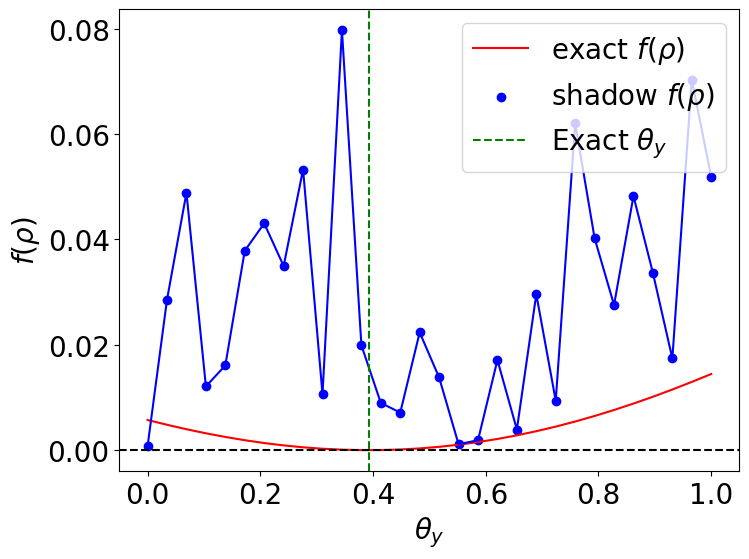

In [16]:
large = 40; med = 20; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
plt.rcParams['text.usetex'] = False
#plt.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'
plt.rcParams.update(params)
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)
plt.plot(theta_y_lst,cost_function_array_exact,c="red",label="exact "+r"$f(\rho)$")
plt.plot(theta_y_lst,cost_function_array_shadow,c="blue")
plt.scatter(theta_y_lst,cost_function_array_shadow,c="blue",label="shadow "+r"$f(\rho)$")

ax = f.gca()
ax.axvline(theta_y_exact, color="green",label=r"Exact $\theta_{y}$",linestyle="--")
ax.axhline(0, color="k",linestyle="--")
#ax.axvline(-np.pi+theta_x_exact, color="green",label = r"$\theta_{x}$",linestyle="--")
#plt.title("Plot of cost function, "+r"$f( \rho ) = \textrm{tr}((\mathcal{L}\rho)^{2})$")
plt.xlabel(r"$\theta_{y}$")
plt.ylabel(r"$f( \rho )$")
plt.legend()
plt.savefig("f_as_function_of_theta_y_5000.jpg",dpi=600)
plt.show()